In [17]:
import gpt_tests
import math

import torch as t
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from einops import rearrange, reduce, repeat
from dataclasses import dataclass
from torch import einsum
from torchtyping import TensorType

In [2]:
DEVICE = t.device("cpu")

In [3]:
class Attention(nn.Module):
    
    def __init__(self, hidden_size: int, num_heads: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_size = hidden_size // num_heads
        self.attn_layer = nn.Linear(hidden_size, 3*hidden_size)
        self.output_layer = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, input: TensorType["batch_size", "seq_len", "hidden_size"], neg_inf=-1e4):
        batch_size, seq_len, hidden_size = input.shape

        # calculate attn_score
        queries, keys, values = t.split(self.attn_layer(input), hidden_size, dim=-1)
        queries = rearrange(queries, "b n (h p)-> b h n p", h=self.num_heads)
        keys = rearrange(keys, "b n (h p) -> b h n p", h=self.num_heads)
        values = rearrange(values, "b n (h p) -> b h n p", h=self.num_heads)
        attn_score = einsum("b h t p, b h f p -> b h t f", queries, keys) / math.sqrt(self.head_size)
        mask = t.ones((seq_len, seq_len), dtype=t.bool, device=DEVICE).triu(diagonal=1)
        mask = repeat(mask, "t f -> b h t f", b=batch_size, h=self.num_heads)
        attn_score[mask] = neg_inf

        # calculate output
        attn_pattern = t.softmax(attn_score, dim=-1)
        attn_concat = einsum("b h t f, b h f p -> b h t p", attn_pattern, values)
        attn_concat = rearrange(attn_concat, "b h t p -> b t (h p)")
        
        return self.output_layer(attn_concat)

In [4]:
gpt_tests.test_unidirectional_attn(Attention)

Congrats! You've passed the test!


In [5]:
class Block(nn.Module):

    def __init__(
        self,
        hidden_size: int,
        num_heads: int,
        dropout: float,
        layer_norm_epsilon: float
    ):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(hidden_size, eps=layer_norm_epsilon)
        self.attention = Attention(hidden_size, num_heads)
        self.layer_norm_2 = nn.LayerNorm(hidden_size, eps=layer_norm_epsilon)
        self.linear_1 = nn.Linear(hidden_size, 4*hidden_size)
        self.linear_2 = nn.Linear(4*hidden_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input: TensorType["batch_size", "seq_len", "hidden_size"]):
        residual_attn = input + self.attention(self.layer_norm_1(input))
        normed_attn = self.layer_norm_2(residual_attn)
        mlp = self.linear_2(F.gelu(self.linear_1(normed_attn)))
        dropout = self.dropout(mlp)
        return residual_attn + dropout


In [6]:
gpt_tests.test_gpt_block(Block)

Congrats! You've passed the test!


In [7]:
@dataclass
class GPT2Output:
    logits: TensorType["batch_size", "vocab_size"]
    final_encoding: TensorType["batch_size", "hidden_size"]

In [8]:
class GPT2(nn.Module):

    def __init__(
        self,
        num_layers: int,
        num_heads: int,
        vocab_size: int,
        hidden_size: int,
        max_position_embeddings: int,
        dropout: float,
        layer_norm_epsilon: float
    ):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_embedding = nn.Embedding(max_position_embeddings, hidden_size)
        self.dropout = nn.Dropout(p=dropout)
        self.blocks = nn.Sequential(
            *(Block(
                hidden_size=hidden_size,
                num_heads=num_heads,
                dropout=dropout,
                layer_norm_epsilon=layer_norm_epsilon
            ) for _ in range(num_layers))
        )
        self.layer_norm = nn.LayerNorm(hidden_size, eps=layer_norm_epsilon)

    def forward(self, input_ids: TensorType["batch_size", "seq_length"]):
        batch_size, seq_len = input_ids.shape
        token_embedding = self.token_embedding(input_ids)
        pos_embedding = self.pos_embedding(t.arange(seq_len, device=DEVICE))
        embedding = self.dropout(token_embedding + pos_embedding)
        block_output = self.blocks(embedding)
        final_encoding = self.layer_norm(block_output)[:,-1,:]
        logits = final_encoding @ self.token_embedding.weight.T
        return GPT2Output(
            logits=logits,
            final_encoding=final_encoding,
        )


In [9]:
gpt_tests.test_gpt(GPT2)

Checking logits:
Congrats! You've passed the test!
Checking final encodings:
Congrats! You've passed the test!


In [10]:
our_gpt = GPT2(num_layers=12, num_heads=12, vocab_size=50257, hidden_size=768, max_position_embeddings=1024, dropout=0.1, layer_norm_epsilon=1e-5)
their_gpt = gpt_tests.get_pretrained_gpt()

In [13]:
def align_state_dicts(our_gpt, their_gpt):
    print(f"{len(our_gpt.state_dict())} {len(their_gpt.state_dict())}")

    for our_key, their_key in zip(our_gpt.state_dict(), their_gpt.state_dict()):
        print(f"{our_key:40}{their_key}")

# align_state_dicts(our_gpt, their_gpt)

In [14]:
def transfer_their_weights_to_ours(our_gpt, their_gpt):
    new_state_dict = {key: their_value for key, their_value in zip(our_gpt.state_dict().keys(), their_gpt.state_dict().values())}
    our_gpt.load_state_dict(new_state_dict)

transfer_their_weights_to_ours(our_gpt=our_gpt, their_gpt=their_gpt)

In [22]:
token_embedding_weight = our_gpt.token_embedding.weight
matrix = t.detach(token_embedding_weight.T @ token_embedding_weight)

In [84]:
normed_matrix = (matrix - matrix.mean()) / matrix.std()

In [85]:
normed_matrix.eig()

torch.return_types.eig(
eigenvalues=tensor([[762.1544,   0.0000],
        [ 21.3803,   0.0000],
        [ 16.9169,   0.0000],
        ...,
        [  1.6872,   0.0000],
        [  1.7315,   0.0000],
        [  1.6936,   0.0000]]),
eigenvectors=tensor([]))

In [82]:
normed_matrix.trace() / 768

tensor(1.1870)

In [87]:
t.norm(normed_matrix - 762.1544 * t.eye(*matrix.shape))

tensor(21033.1270)

In [64]:
matrix.abs().trace() / matrix.abs().sum(dim=1).mean()

tensor(9.7719)

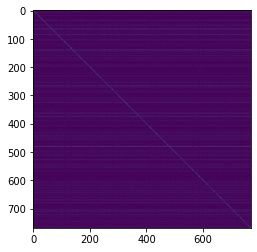

In [65]:
plt.imshow(t.abs(matrix) / t.norm(matrix, dim=0, keepdim=True))

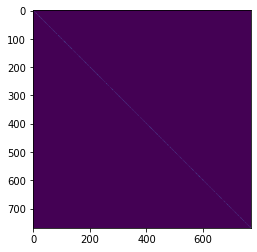

In [68]:
plt.imshow(t.eye(*matrix.shape) / t.norm(matrix, dim=0, keepdim=True))